## Фаза 1. Неделя 1. Среда
### Введение в AB-тесты

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import datetime as dt #для преобразования строк в даты
import numpy as np
import matplotlib.pyplot as plt

#заказы
orders = pd.read_csv('/content/drive/MyDrive/ds-phase-1/Неделя 1/ср/data_for_tasks_3.csv', sep=',')
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%d/%m/%Y')
)

#посетители
visitors = pd.read_csv('/content/drive/MyDrive/ds-phase-1/Неделя 1/ср/data_for_tasks_3_visitors.csv', sep=',')
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%d/%m/%Y')
)

orders.head()

,userId,group,orderId,revenue,date
0,1.815263e+19,B,4.612878e+15,489,2019-04-22
1,1.815263e+19,B,4.612878e+15,489,2019-04-22
2,1.794078e+19,B,4.136278e+18,97,2019-04-22
3,1.794078e+19,B,4.136278e+18,279,2019-04-22
4,2.461477e+18,B,1.406554e+19,4092,2019-04-22


In [ ]:
visitors.head()

,date,group,visitors
0,2019-03-11,A,321
1,2019-03-12,A,831
2,2019-03-13,A,700
3,2019-03-14,A,1222
4,2019-03-15,A,859


In [ ]:
# Берем все уникальные комбинации (дата, группа)
# Например: (2019-03-11, A), (2019-03-11, B), (2019-03-12, A) и т.д.
datesGroups = orders[['date', 'group']].drop_duplicates()

# === КУМУЛЯТИВНЫЕ ЗАКАЗЫ ===
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        # Фильтруем все заказы до текущей даты (включительно) и по текущей группе
        np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])
    ].agg({
        'date' : 'max',                   # текущая дата
        'group' : 'max',                  # группа (A или B)
        'orderId' : pd.Series.nunique,    # число уникальных заказов
        'userId' : pd.Series.nunique,     # число уникальных покупателей
        'revenue' : 'sum'                 # суммарная выручка
    }), axis=1).sort_values(by=['date','group'])

# === КУМУЛЯТИВНЫЕ ВИЗИТЫ ===
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        # Фильтруем всех посетителей до текущей даты (включительно) и по текущей группе
        np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])
    ].agg({
        'date' : 'max',          # текущая дата
        'group' : 'max',         # группа
        'visitors' : 'sum'       # общее число визитов до этой даты
    }), axis=1).sort_values(by=['date','group'])

# === ОБЪЕДИНЯЕМ ЗАКАЗЫ И ВИЗИТЫ ===
cumulativeData = ordersAggregated.merge(
    visitorsAggregated,
    left_on=['date', 'group'],
    right_on=['date', 'group']
)

# Переименовываем колонки для удобства
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# Смотрим первые строки итоговой таблицы
print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-03-11     A      10      10   110291       321
1 2019-03-11     B       9       9    36646       337
2 2019-03-12     A      35      33   343089      1152
3 2019-03-12     B      35      33    90491      1198
4 2019-03-13     A      59      56  1012663      1852


Теперь у тебя таблица cumulativeData, где по каждой дате и группе собраны:

- число заказов (orders),

- число покупателей (buyers),

- выручка (revenue),

- число визитов (visitors).

Эти данные можно использовать для расчёта метрик (например, CR = orders / visitors, ARPU = revenue / visitors).

CR - какая доля посетителей стала покупателями

ARPPU - Сколько в среднем тратит один покупатель?

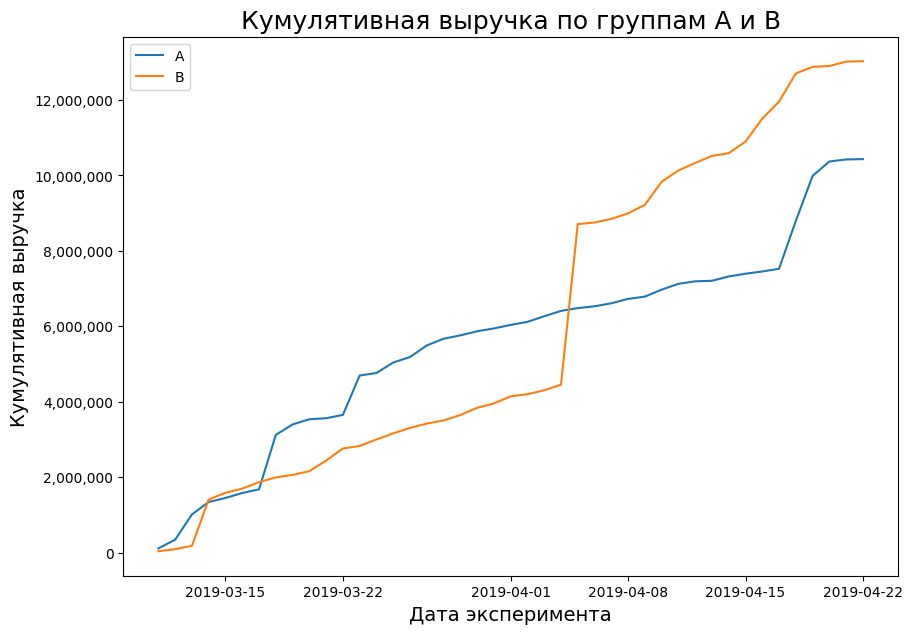

In [ ]:
import matplotlib.ticker as ticker

# Отбираем данные только для группы A: дата, выручка и количество заказов
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# Отбираем данные только для группы B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]


# === Строим график кумулятивной выручки ===
plt.figure(figsize=(10,7))   # размер графика

# Группа A
plt.plot(cumulativeRevenueA['date'],
         cumulativeRevenueA['revenue'],
         label='A')

# Группа B
plt.plot(cumulativeRevenueB['date'],
         cumulativeRevenueB['revenue'],
         label='B')
plt.legend()
plt.xlabel("Дата эксперимента", size=14)
plt.ylabel("Кумулятивная выручка", size=14)
plt.title("Кумулятивная выручка по группам A и B", size=18)

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

- После 5–7 апреля группа B резко вырывается вперёд (оранжевая линия идёт выше синей).  Экспериментальная группа приносит существенно больше выручки, чем контроль.

- К концу эксперимента (20-е числа апреля) разрыв закрепляется:
B ≈ 13 млн ₽
A ≈ 10.5 млн ₽
Разница около +2.5 млн ₽ в пользу экспериментальной группы.

Экспериментальная группа B показала более высокую кумулятивную выручку.
Если статистические тесты подтвердят значимость разницы (p-value < 0.05), то изменения в группе B можно считать успешными — они увеличили доход.

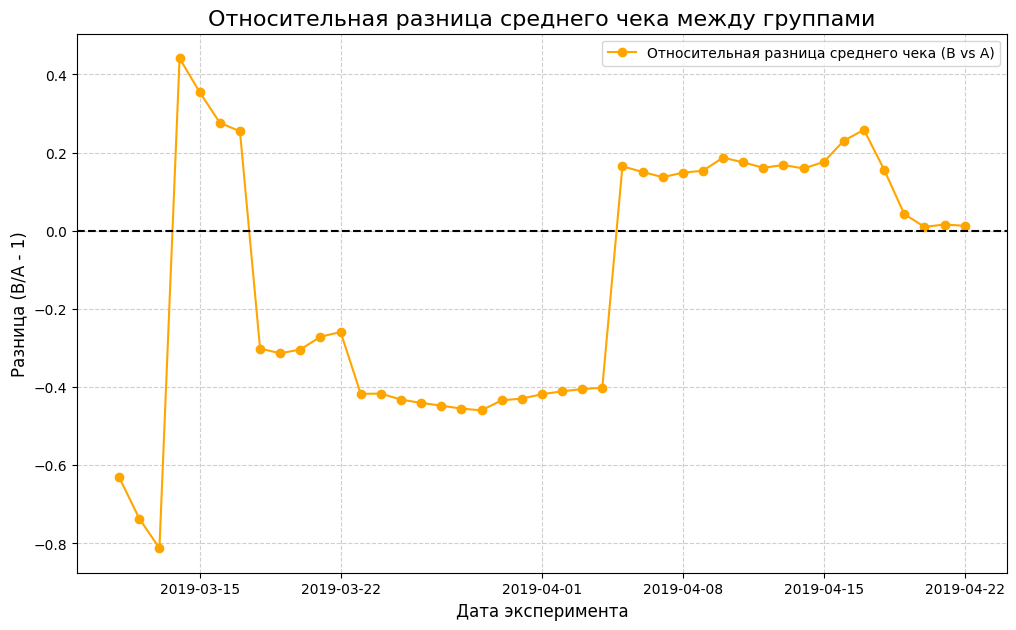

In [ ]:
plt.figure(figsize=(12,7))

# Склеиваем данные по кумулятивной выручке и заказам
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB,
    left_on='date',
    right_on='date',
    how='left',
    suffixes=['A', 'B']
)

# Считаем отношение среднего чека в группе B к группе A - 1
relative_avg_order_value = (
    (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB']) /
    (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA']) - 1
)

plt.plot(
    mergedCumulativeRevenue['date'],
    relative_avg_order_value,
    marker='o',
    color='orange',
    label='Относительная разница среднего чека (B vs A)'
)

plt.axhline(y=0, color='black', linestyle='--')

plt.title("Относительная разница среднего чека между группами", fontsize=16)
plt.xlabel("Дата эксперимента", fontsize=12)
plt.ylabel("Разница (B/A - 1)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

- Ось Y (Разница B/A − 1) — относительное отличие среднего чека в группе B от группы A:

0 → средний чек в B выше, чем в A.

<0 → средний чек в B ниже, чем в A.

- Ось X (Дата эксперимента) — ход эксперимента во времени.

📝 Вывод:

- На протяжении эксперимента средний чек “скакал”: то выше в группе B, то ниже.

- Такие скачки говорят о влиянии выбросов (редких крупных заказов).

- В итоге, к концу теста, разницы между группами практически нет →
сам по себе средний чек не улучшился в группе B.

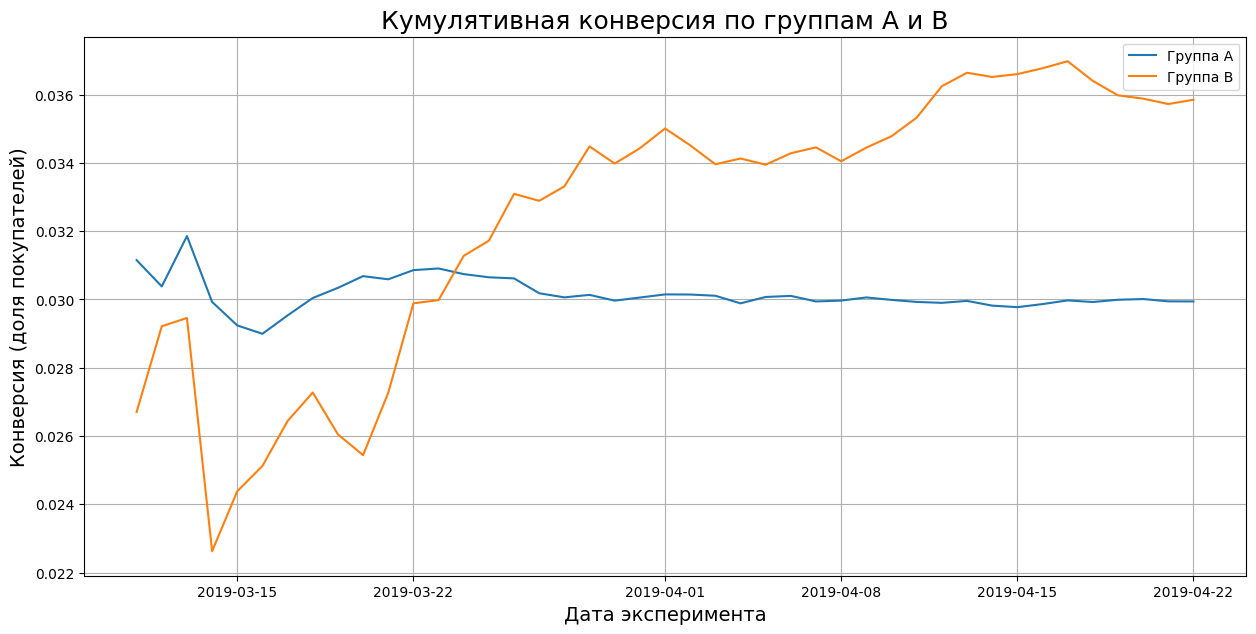

In [ ]:
# CR

# Добавляем колонку с конверсией (число заказов / число посетителей)
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

# Данные отдельно для группы A и B
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

plt.figure(figsize=(15, 7))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='Группа A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='Группа B')

plt.title('Кумулятивная конверсия по группам A и B', fontsize=18)
plt.xlabel('Дата эксперимента', fontsize=14)
plt.ylabel('Конверсия (доля покупателей)', fontsize=14)
plt.legend()
plt.grid(True)

plt.show()

- Группа A (синяя линия): Конверсия держится примерно на уровне 3% (0.03).
- Группа B (оранжевая линия): К концу эксперимента конверсия в B вышла на 3.6%, что заметно выше, чем у A.

В начале теста мог быть "шум" (резкие колебания из-за малого числа данных).

Но к концу эксперимента видно устойчивое преимущество группы B над A по конверсии.

Разница в пользу группы B составляет примерно 3.6% vs 3.0% (0.6), что довольно значимо для реального бизнеса.

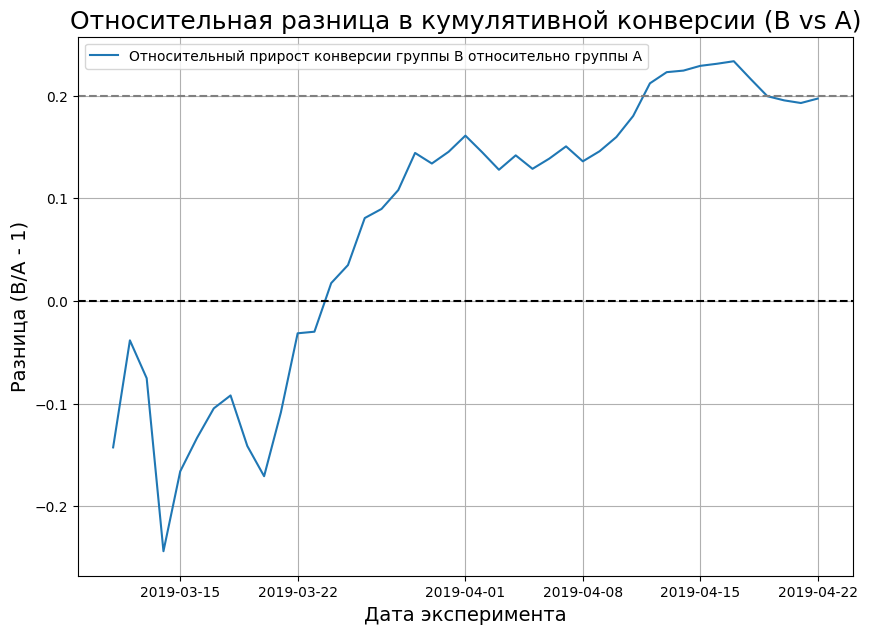

In [ ]:
# === Считаем относительный прирост конверсии B относительно A ===
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']],
    on='date',          # объединяем по дате
    how='left',
    suffixes=['A', 'B']
)

plt.figure(figsize=(10, 7))

# Относительная разница: (B/A - 1) → если > 0, то B лучше A
plt.plot(
    mergedCumulativeConversions['date'],
    mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA'] - 1,
    label="Относительный прирост конверсии группы B относительно группы A"
)

plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')

plt.title("Относительная разница в кумулятивной конверсии (B vs A)", fontsize=18)
plt.xlabel("Дата эксперимента", fontsize=14)
plt.ylabel("Разница (B/A - 1)", fontsize=14)
plt.grid(True)
plt.show()

- Начиная с конца марта, линия стабильно держится выше нуля → это значит, что группа B имеет конверсию выше, чем группа A.

- К концу теста разница достигает около +20% (0.2) — то есть, конверсия группы B примерно на 20% выше, чем у A.